# VAE

In [1]:
import sys
import os
import seaborn as sns
sys.path.append( '..' )

from VAE.smac_runhistories import *
from VAE.vae import *

## Parameter definition

In [2]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together/oms"))
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/hyperparameter_optimization"))
results_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/results"))
verbosity = 1
backend_name = "tensorflow"
computation = "gpu"
outdir = Path(os.path.normpath(os.path.join(run_dir, f"smac_vae_{backend_name}_{computation}")))

time_step(message="Setup loaded", verbosity=verbosity)

X = read_data(data_dir, verbosity=verbosity)

Setup loaded (0.5388052463531494s)
Data loaded (107.12997174263s)


## Search interpretation

In [15]:
import ast
import scipy

In [4]:
results = pd.read_csv(os.path.join(results_dir, "results_hp_search.tsv"), sep="\t")
results

,Unnamed: 0,config_id,config,instance,budget,seed,loss,time,status,additional_info
0,0,1,"{'input_dropout': 0.2744067519636624, 'interme...",NaN,3.703704,209652396,4.287091,5.946154,1,{}
1,1,2,"{'input_dropout': 0.35759468318620974, 'interm...",NaN,3.703704,209652396,5.677361,3.575746,1,{}
2,2,3,"{'input_dropout': 0.30138168803582194, 'interm...",NaN,3.703704,209652396,1.626674,1.867249,1,{}
3,3,4,"{'input_dropout': 0.27244159149844843, 'interm...",NaN,3.703704,209652396,1.753383,3.445244,1,{}
4,4,5,"{'input_dropout': 0.21182739966945235, 'interm...",NaN,3.703704,209652396,8.027390,0.957173,1,{}
...,...,...,...,...,...,...,...,...,...,...
13105,13105,9191,"{'input_dropout': 0.06321367748265289, 'interm...",NaN,3.703704,209652396,3.021076,1.330938,1,{}
13106,13106,9180,"{'input_dropout': 0.13923965638943803, 'interm...",NaN,11.111111,209652396,0.926140,4.534626,1,{}
13107,13107,9183,"{'input_dropout': 0.26701624577176075, 'interm...",NaN,11.111111,209652396,0.030942,1.763532,1,{}
13108,13108,9169,"{'input_dropout': 0.08636796183064274, 'interm...",NaN,11.111111,209652396,1.189073,4.358716,1,{}


In [48]:
config_df = pd.DataFrame([ast.literal_eval(config) for config in results["config"].to_list()])
hyperparameters = ["input_dropout", "intermediate_dimension", "intermediate_layers", "latent_dimension", "learning_rate"]
plt_df = pd.concat([config_df[hyperparameters], results[["loss", "budget"]]], axis=1)

In [118]:
plt_df["true_layers"] = plt_df["intermediate_layers"]
for i in plt_df.index:
    for j in range(plt_df.loc[i, "intermediate_layers"]):
        if plt_df.loc[i, "intermediate_dimension"] // 2**j < plt_df.loc[i, "latent_dimension"]:
            plt_df.loc[i, "true_layers"]  = min(j, plt_df.loc[i, "intermediate_layers"])
            break
hyperparameters.remove("intermediated_layers")

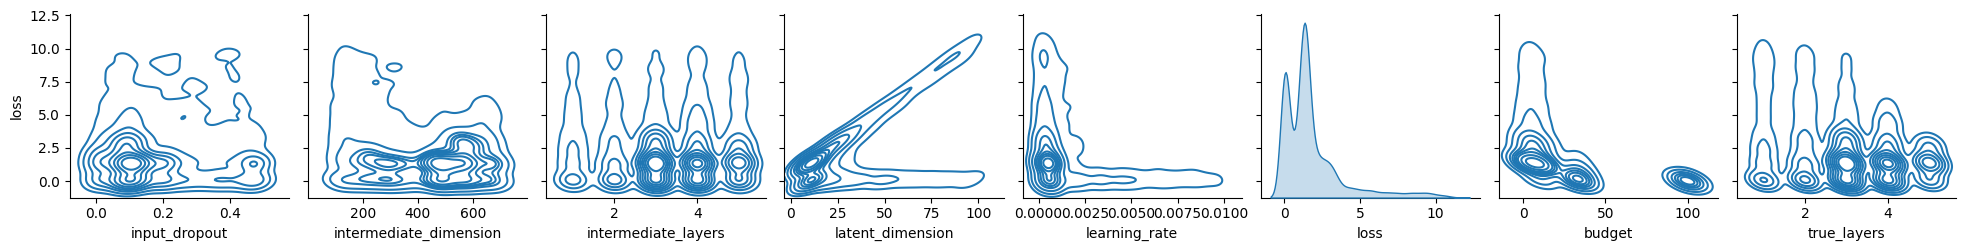

In [120]:
ax1 = sns.pairplot(plt_df,
             x_vars=hyperparameters + "true_layers",
             y_vars=['loss'],
             kind="kde")

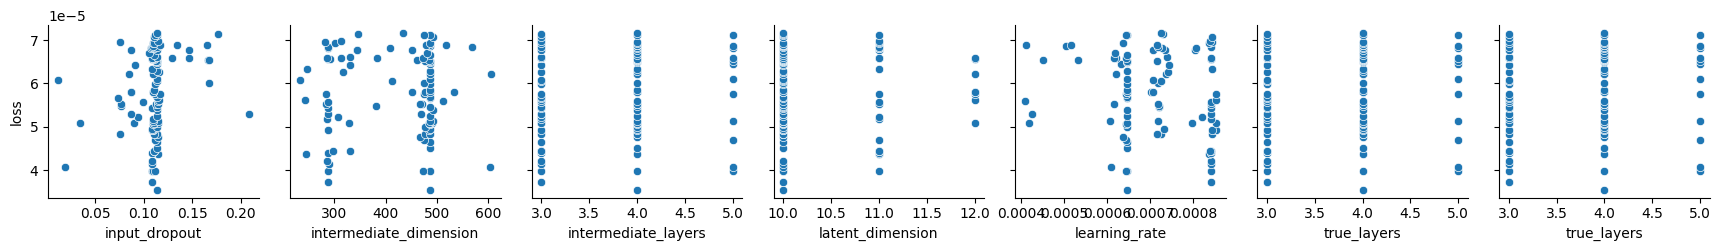

In [121]:
ax2 = sns.pairplot(plt_df.sort_values("loss", ascending=True)[0:100],
             x_vars=hyperparameters,
             y_vars=['loss'])

<Axes: xlabel='intermediate_activation', ylabel='loss'>

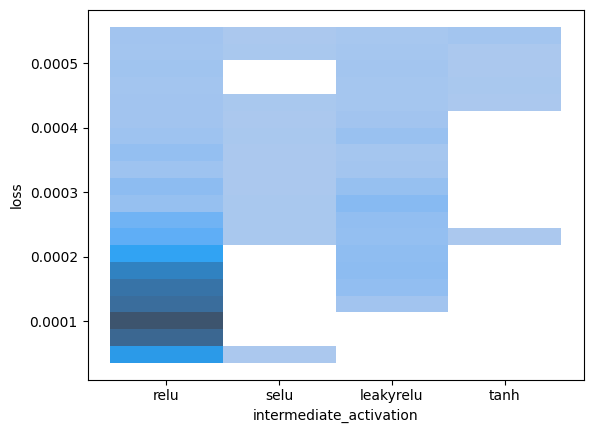

In [62]:
sns.histplot(plt_df.sort_values("loss", ascending=True)[0:1000], x="intermediate_activation", y="loss")

In [77]:
for hp in hyperparameters:
    corr = scipy.stats.spearmanr(plt_df[hp], 1-plt_df["loss"]).statistic
    print(f"Pearson correlation of {hp} and loss: {corr}")

Pearson correlation of input_dropout and loss: -0.11431856122384046
Pearson correlation of intermediate_dimension and loss: 0.15520304157725182
Pearson correlation of intermediate_layers and loss: 0.05988409220446543
Pearson correlation of latent_dimension and loss: -0.6258248691675299
Pearson correlation of learning_rate and loss: 0.11406141401488774
Pearson correlation of true_layers and loss: 0.02425535302042016


## Training

In [8]:
# On cluster
backend_name = "tensorflow"
computation = "cpu"
name = "fin" # "tied_fin"
project = f"vae_{backend_name}_{computation}_{name}"
outdir = Path(os.path.normpath( os.path.join("/mnt/d/runs/VAE/training", project)))

In [9]:
model = keras.saving.load_model(os.path.join(outdir, f"{project}.keras"), custom_objects=None, compile=True, safe_mode=True)
model.load_weights(os.path.join(outdir, f"{project}.weights.h5"))

In [29]:
model.summary()

Model: "fia_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │   619,125,435 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │             0 │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │   619,950,415 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,717,230,073 (13.85 GB)

 Trainable params: 1,239,076,690 (4.62 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,478,153,383 (9.23 GB)

## Reconstruction

In [33]:
X

mz,50.001,50.003,50.005,50.007,50.009,50.011,50.013,50.015,50.017,50.019,...,1699.981,1699.983,1699.985,1699.987,1699.989,1699.991,1699.993,1699.995,1699.997,1699.999
msAV206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
msAV207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
msAV208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
msAV209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
msAV210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
msAV308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
msAV309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
msAV310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
msAV311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
reconstructed_data = pd.DataFrame(model(X).numpy())

### Show model

In [38]:
model_plot = keras.utils.model_to_dot(
                                        model,
                                        show_shapes=True,
                                        show_dtype=False,
                                        show_layer_names=True,
                                        rankdir="TB",
                                        expand_nested=True,
                                        dpi=300,
                                        subgraph=True,
                                        show_layer_activations=True,
                                        show_trainable=True
                                    )
model_plot

## Plot training

In [4]:
history = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.history.tsv", sep="\t", index_col="Unnamed: 0")
history

,kl_loss,loss,reconstruction_loss,val_kl_loss,val_loss,val_reconstruction_loss
0,0.000000,0.005439,0.005439,0.020408,0.020434,0.000026
1,0.078654,0.078680,0.000026,0.012319,0.012320,0.000001
2,0.047462,0.047464,0.000001,0.005980,0.005982,0.000001
3,0.023067,0.023068,0.000001,0.002579,0.002581,0.000001
4,0.009951,0.009952,0.000001,0.001427,0.001428,0.000001
...,...,...,...,...,...,...
95,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001
96,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001
97,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001
98,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001


In [5]:
training_losses = history[[col for col in history.columns if not col.startswith("val")]]
validation_losses = history[[col for col in history.columns if col.startswith("val")]]

## Plot results

In [13]:
# reconstructed_data = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.prediction.tsv", index_col="Unnamed: 0")#, sep="\t")

In [47]:
plot_df = pd.DataFrame(reconstructed_data.loc[3].values, index=X.columns, columns=["inty"]).reset_index()
plot_df_2 = pd.DataFrame(X.iloc[3].values, index=X.columns, columns=["inty"]).reset_index()

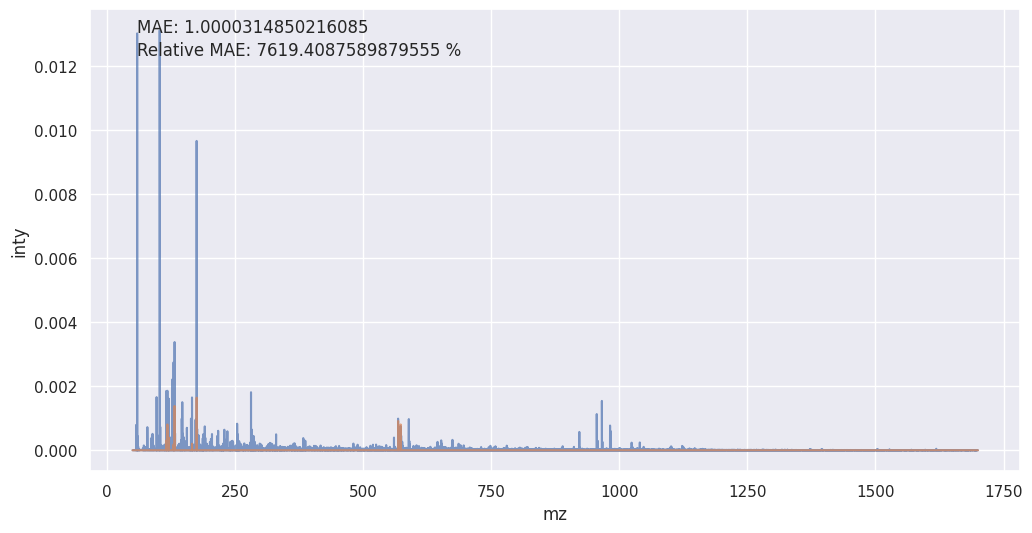

In [48]:
mae = np.mean(np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) ))
rel_mae = mae / np.max(plot_df_2["inty"])

sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f"Relative MAE: {rel_mae *100} %", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()

(965.9, 966.1)

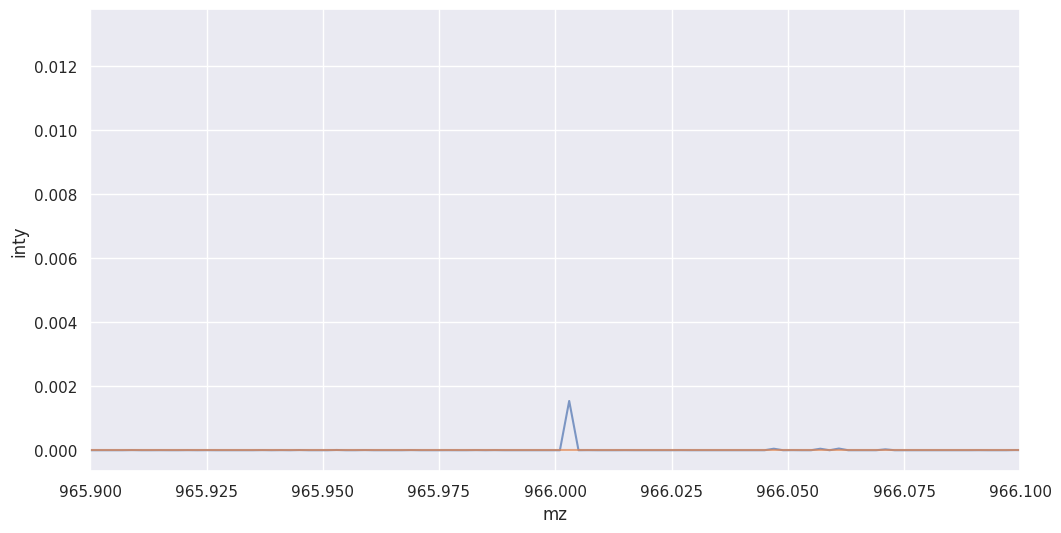

In [49]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(965.9, 966.1)

(-0.0001, 0.003)

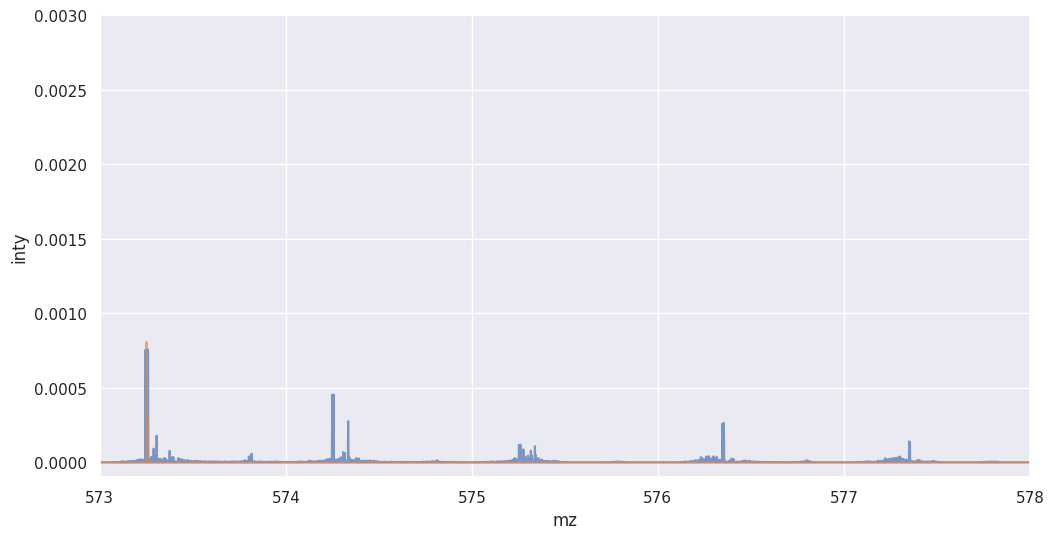

In [50]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

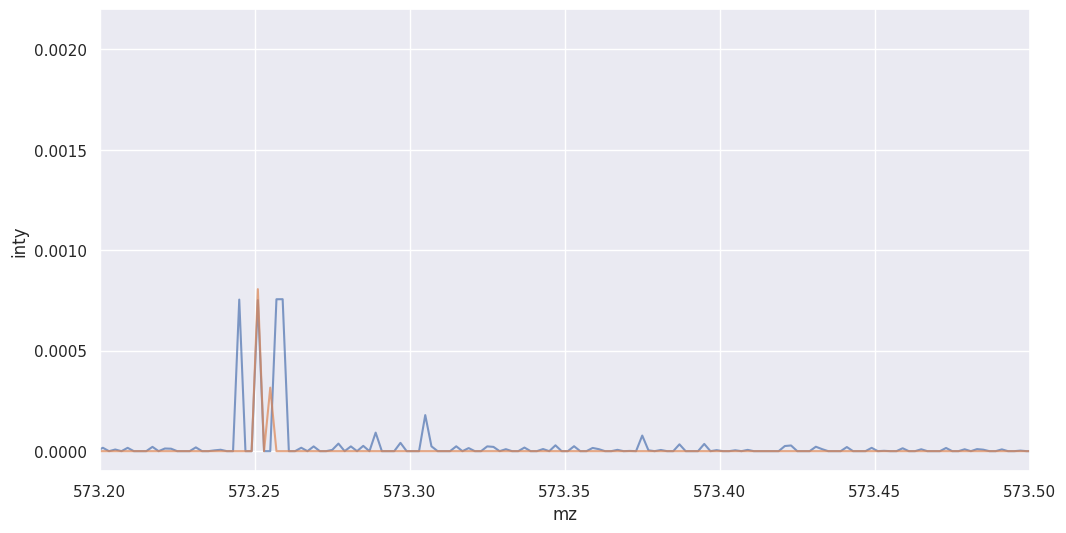

In [51]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

## Classification

In [52]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")

In [55]:
vae_enc = pd.DataFrame( model.encode_mu(X) )
vae_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000012,-0.000016,-0.000013,-0.000026,0.000008,-0.000020,0.000007,9.349833e-07,0.000014,0.000013,-0.000053,-0.000035,-0.000002,-0.000010,-3.682797e-06,0.000014,0.000007,0.000030,0.000043,-1.975632e-06
1,0.000011,-0.000014,-0.000014,-0.000027,0.000009,-0.000020,0.000008,2.326378e-07,0.000013,0.000014,-0.000053,-0.000036,-0.000002,-0.000010,-4.357596e-06,0.000012,0.000009,0.000029,0.000041,-1.605015e-06
2,0.000013,-0.000017,-0.000014,-0.000026,0.000009,-0.000020,0.000007,-1.576780e-06,0.000012,0.000014,-0.000053,-0.000034,-0.000003,-0.000011,-5.216563e-06,0.000011,0.000009,0.000030,0.000041,-4.687145e-07
3,0.000013,-0.000015,-0.000013,-0.000027,0.000008,-0.000021,0.000008,6.659529e-07,0.000014,0.000013,-0.000053,-0.000034,-0.000002,-0.000010,-3.965164e-06,0.000013,0.000009,0.000029,0.000042,-2.627074e-06
4,0.000012,-0.000014,-0.000013,-0.000026,0.000009,-0.000020,0.000007,3.820060e-08,0.000014,0.000013,-0.000053,-0.000035,-0.000003,-0.000010,-3.462603e-06,0.000013,0.000009,0.000030,0.000043,-2.317770e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.000012,-0.000015,-0.000012,-0.000026,0.000010,-0.000021,0.000008,6.570899e-07,0.000014,0.000013,-0.000054,-0.000036,-0.000003,-0.000009,-3.925461e-06,0.000013,0.000009,0.000030,0.000043,-2.338627e-06
64,0.000012,-0.000015,-0.000013,-0.000026,0.000009,-0.000020,0.000007,4.930080e-07,0.000013,0.000013,-0.000053,-0.000034,-0.000003,-0.000011,-4.398651e-06,0.000012,0.000009,0.000029,0.000042,-2.028784e-06
65,0.000012,-0.000015,-0.000013,-0.000026,0.000010,-0.000020,0.000008,2.795805e-07,0.000014,0.000013,-0.000053,-0.000035,-0.000004,-0.000009,-3.180223e-06,0.000013,0.000008,0.000030,0.000043,-1.906870e-06
66,0.000012,-0.000015,-0.000015,-0.000026,0.000008,-0.000018,0.000007,-8.836842e-07,0.000014,0.000014,-0.000051,-0.000032,-0.000001,-0.000012,-3.799989e-06,0.000015,0.000007,0.000030,0.000041,-6.686696e-07


In [ ]:
vae_enc.to_csv( os.path.join(, "encoded_mu.tsv"), sep="\t" )